In [1]:
!pip install optuna

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

device

device(type='cuda')

In [4]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [5]:
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 160kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.11MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.6MB/s]


In [6]:
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

Label: 9
Image shape: torch.Size([1, 28, 28])


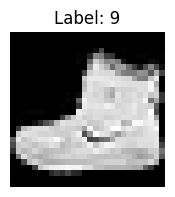

In [7]:
import matplotlib.pyplot as plt

X1, y1 = train_data[0]
print("Label:", y1)
print("Image shape:", X1.shape)

plt.figure(figsize=(2, 3))
plt.imshow(X1.squeeze(), cmap="gray")
plt.title(f"Label: {y1}")
plt.axis("off")
plt.show()

In [8]:
class MyOptunaNN(nn.Module):
  def __init__(self, input_dim,output_dim, hidden_units, neurons_per_layer, dropout_rate):
    super().__init__()
    layers = []
    layers.append(nn.Flatten())
    layers.append(nn.Linear(input_dim, input_dim))
    layers.append(nn.BatchNorm1d(input_dim))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(p=dropout_rate))
    for i in range(hidden_units-1):
      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(p=dropout_rate))
      input_dim = neurons_per_layer
    layers.append(nn.Linear(input_dim, output_dim))
    self.ANN = nn.Sequential(*layers)

  def forward(self,x):
    return self.ANN(x)

In [9]:
# objective function
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 2, 3, step=1)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 16, 128, step=16)
  epochs = trial.suggest_int("epochs", 10, 70, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [50,100])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyOptunaNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

  if optimizer_name == 'Adam':
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()


  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [10]:
study = optuna.create_study(direction="maximize")

[I 2025-09-03 15:14:53,086] A new study created in memory with name: no-name-ee698319-0b8c-49e8-8c91-70ef5a4149d0


In [15]:
study.optimize(objective, n_trials=6)


[I 2025-09-03 14:49:17,031] Trial 0 finished with value: 0.8801 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 32, 'epochs': 10, 'learning_rate': 0.02277738788107614, 'dropout_rate': 0.30000000000000004, 'batch_size': 100, 'optimizer': 'RMSprop', 'weight_decay': 0.00011262827325735321}. Best is trial 0 with value: 0.8801.
[I 2025-09-03 14:58:47,887] Trial 1 finished with value: 0.9008 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 128, 'epochs': 70, 'learning_rate': 3.753611905785061e-05, 'dropout_rate': 0.30000000000000004, 'batch_size': 50, 'optimizer': 'RMSprop', 'weight_decay': 3.723107333366884e-05}. Best is trial 1 with value: 0.9008.
[I 2025-09-03 15:00:14,962] Trial 2 finished with value: 0.8834 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 96, 'epochs': 10, 'learning_rate': 0.0012862187752570502, 'dropout_rate': 0.30000000000000004, 'batch_size': 50, 'optimizer': 'Adam', 'weight_decay': 0.0002633515843894752}. Best is trial 1 with

In [16]:

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [17]:
train_loader = DataLoader(train_data, batch_size=50, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=50, shuffle=False, pin_memory=True)

In [19]:
class BestNN(nn.Module):
    def __init__(self, input_dim=784, output_dim=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 784),
            nn.BatchNorm1d(784),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(784, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.model(x)


epochs = 70
batch_size = 50
learning_rate = 3.75e-05
weight_decay = 3.72e-05


model = BestNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/70], Loss: 0.7463
Epoch [2/70], Loss: 0.4939
Epoch [3/70], Loss: 0.4266
Epoch [4/70], Loss: 0.3921
Epoch [5/70], Loss: 0.3678
Epoch [6/70], Loss: 0.3463
Epoch [7/70], Loss: 0.3354
Epoch [8/70], Loss: 0.3207
Epoch [9/70], Loss: 0.3111
Epoch [10/70], Loss: 0.3022
Epoch [11/70], Loss: 0.2936
Epoch [12/70], Loss: 0.2865
Epoch [13/70], Loss: 0.2754
Epoch [14/70], Loss: 0.2725
Epoch [15/70], Loss: 0.2644
Epoch [16/70], Loss: 0.2563
Epoch [17/70], Loss: 0.2516
Epoch [18/70], Loss: 0.2471
Epoch [19/70], Loss: 0.2424
Epoch [20/70], Loss: 0.2372
Epoch [21/70], Loss: 0.2299
Epoch [22/70], Loss: 0.2268
Epoch [23/70], Loss: 0.2206
Epoch [24/70], Loss: 0.2166
Epoch [25/70], Loss: 0.2153
Epoch [26/70], Loss: 0.2116
Epoch [27/70], Loss: 0.2074
Epoch [28/70], Loss: 0.2020
Epoch [29/70], Loss: 0.1983
Epoch [30/70], Loss: 0.1975
Epoch [31/70], Loss: 0.1920
Epoch [32/70], Loss: 0.1888
Epoch [33/70], Loss: 0.1844
Epoch [34/70], Loss: 0.1832
Epoch [35/70], Loss: 0.1792
Epoch [36/70], Loss: 0.1766
E

In [20]:
model.eval()
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.901


In [21]:
model.eval()
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9842666666666666


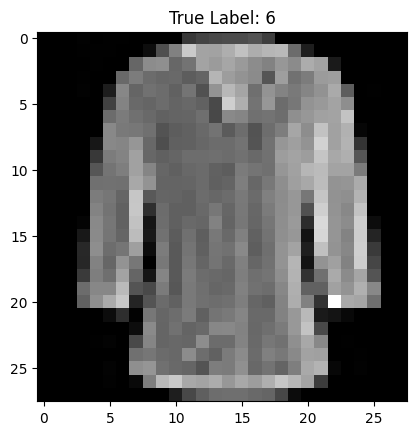

In [25]:

import matplotlib.pyplot as plt

img, label = test_data[4]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"True Label: {label}")
plt.show()

In [26]:
x = img.view(-1, 28*28)   # flatten (1, 784)

In [27]:
model.eval()
with torch.no_grad():
    x = x.to(device)
    outputs = model(x)
    max_prob, predicted = torch.max(outputs, 1)

In [28]:
import torch.nn.functional as F

model.eval()
with torch.no_grad():
    outputs = model(x)
    probs = F.softmax(outputs, dim=1)  # convert logits → probabilities
    max_prob, predicted = torch.max(probs, 1)  # max prob & class index

print("Predicted class index:", predicted.item())
print("Max Probability:", max_prob.item())
print("True Label:", label)

Predicted class index: 6
Max Probability: 0.9484632015228271
True Label: 6
